# Time Series pipeline experiment version 1.0

# Load Dependencies

In [1]:
pip install pmdarima 

     |████████████████████████████████| 1.5 MB 402 kB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install holidays 

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
#########
# Modules 
#########

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import itertools 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
import xgboost as xgb
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nyse/fundamentals.csv
/kaggle/input/nyse/prices.csv
/kaggle/input/nyse/securities.csv
/kaggle/input/nyse/prices-split-adjusted.csv
/kaggle/input/hourly-energy-consumption/DUQ_hourly.csv
/kaggle/input/hourly-energy-consumption/AEP_hourly.csv
/kaggle/input/hourly-energy-consumption/est_hourly.paruqet
/kaggle/input/hourly-energy-consumption/DEOK_hourly.csv
/kaggle/input/hourly-energy-consumption/FE_hourly.csv
/kaggle/input/hourly-energy-consumption/NI_hourly.csv
/kaggle/input/hourly-energy-consumption/EKPC_hourly.csv
/kaggle/input/hourly-energy-consumption/DOM_hourly.csv
/kaggle/input/hourly-energy-consumption/COMED_hourly.csv
/kaggle/input/hourly-energy-consumption/PJME_hourly.csv
/kaggle/input/hourly-energy-consumption/PJM_Load_hourly.csv
/kaggle/input/hourly-energy-consumption/pjm_hourly_est.csv
/kaggle/input/hourly-energy-consumption/DAYTON_hourly.csv
/kaggle/input/hourly-energy-consumption/PJMW_hourly.csv


# 1. Preprocessing

In [56]:
dfx = pd.read_csv('/kaggle/input/nyse/prices-split-adjusted.csv')

#df1 = pd.read_csv('/kaggle/input/nyse/prices-split-adjusted.csv',parse_dates=True, index_col = 'date')
#df = pd.DataFrame(df['volume'])
#m = pd.DataFrame(df.resample(rule='MS').volume.sum())
#d = pd.DataFrame(df.resample(rule='d').volume.sum())

In [57]:
# Daily split 

dfx = pd.DataFrame(dfx.groupby('date')['volume'].sum())
df1 = dfx.copy()
df1.head()

,volume
date,
2010-01-04,2.819820e+09
2010-01-05,3.505330e+09
2010-01-06,3.359974e+09
2010-01-07,3.732438e+09
2010-01-08,3.076340e+09


# 2. Sarima model method 1

In [58]:
stock = pd.read_csv('../input/nyse/prices-split-adjusted.csv')
df1 = stock.reset_index()['close']
daily = dfx.copy()

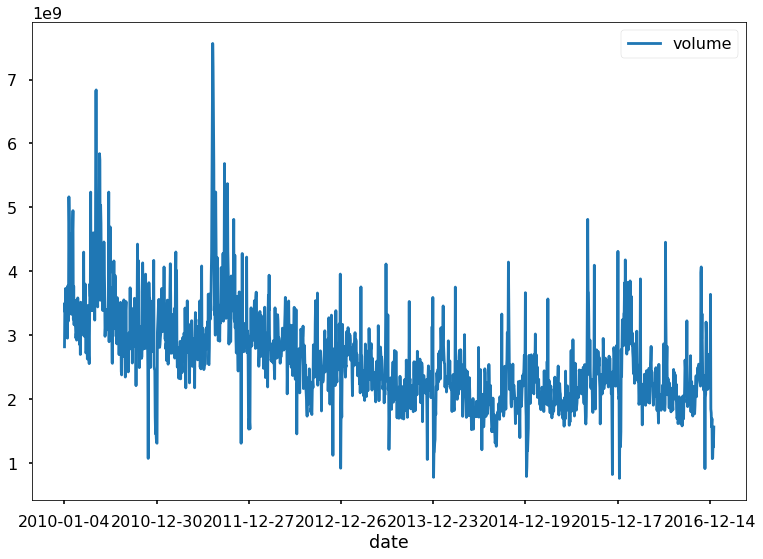

In [59]:
daily.plot()

In [60]:
# Define datasets 

# stock df 
stock['date'] = pd.to_datetime(stock['date'])
stock.set_index('date', inplace=True)

# daily
daily.reset_index(inplace=True)
daily['date'] = pd.to_datetime(daily['date'])
daily.set_index('date', inplace=True)

In [61]:
stock.head()

,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [84]:
# 1 Resample 
monthly_var1 = pd.DataFrame(stock.resample('M').sum()) # to avoid converting to data frame I could choose all the columns
monthly_var2 = pd.DataFrame(daily.resample('M').sum()) # to avoid converting to data frame I could choose all the columns

current_df = monthly_var1

In [85]:
current_df.head()

,open,close,low,high,volume
date,,,,,
2010-01-31,346587.459010,345802.713007,341713.277559,350357.006298,7.041815e+10
2010-02-28,335768.382604,336518.309560,331862.291954,339679.152323,6.597997e+10
2010-03-31,433386.848929,434229.140022,429755.575339,437860.574990,7.330653e+10
2010-04-30,414731.633427,415253.465763,410156.015239,419535.287743,7.527794e+10
2010-05-31,377316.038970,376518.447190,369515.871088,383192.415258,9.128969e+10


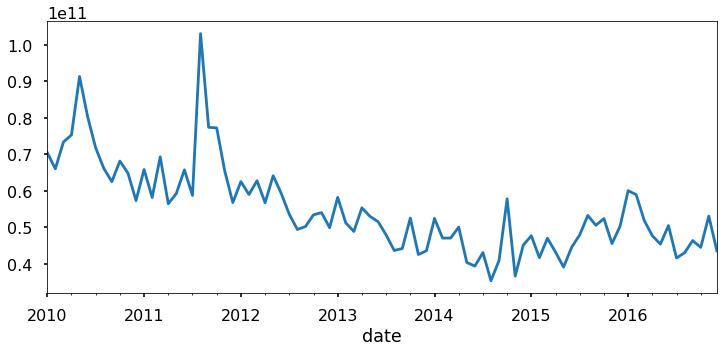

In [86]:
current_df.volume.plot(figsize=(12,5))

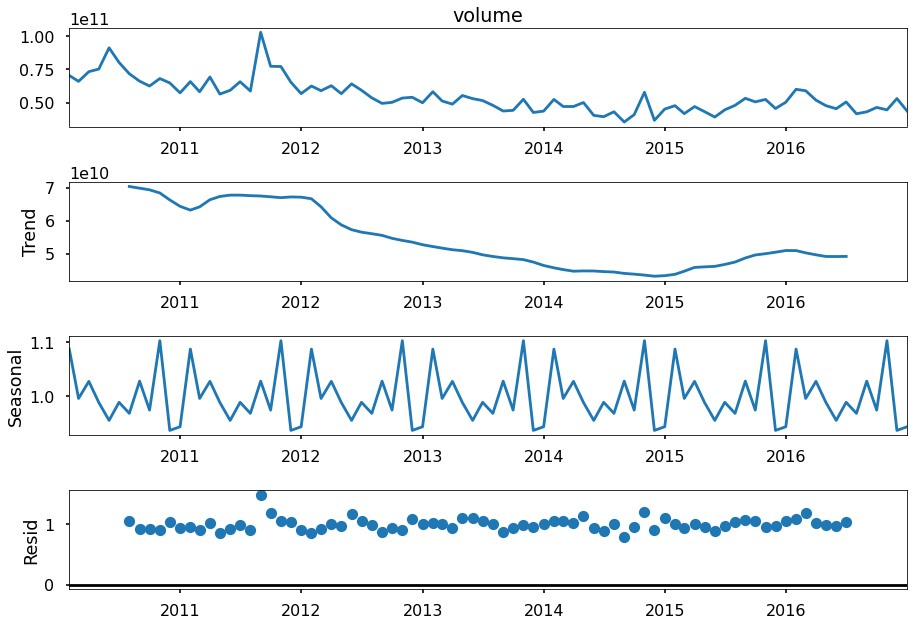

In [87]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(current_df.volume,model='multiplicative')
result.plot();

In [88]:
# Check if the data is stationary
from statsmodels.tsa.stattools import adfuller
print("Dickey–Fuller test: p=%f" % adfuller(current_df.volume)[1])

# Data is non stationary
#Dickey–Fuller test: p=0.140849

Dickey–Fuller test: p=0.140849


In [89]:
# 1 Make the data stationary

current_df['Sales First Difference'] = current_df.volume - current_df.volume.shift(1)


In [90]:
current_df.head()

,open,close,low,high,volume,Sales First Difference
date,,,,,,
2010-01-31,346587.459010,345802.713007,341713.277559,350357.006298,7.041815e+10,NaN
2010-02-28,335768.382604,336518.309560,331862.291954,339679.152323,6.597997e+10,-4.438186e+09
2010-03-31,433386.848929,434229.140022,429755.575339,437860.574990,7.330653e+10,7.326564e+09
2010-04-30,414731.633427,415253.465763,410156.015239,419535.287743,7.527794e+10,1.971413e+09
2010-05-31,377316.038970,376518.447190,369515.871088,383192.415258,9.128969e+10,1.601175e+10


In [91]:
#  adfuller test
def adfuller_test(sales):
    result= adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [92]:
adfuller_test(current_df['Sales First Difference'].dropna())

ADF Test Statistic : -7.755954636279377
p-value : 9.736787835844048e-12
#Lags Used : 3
Number of Observations Used : 79
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [93]:
adfuller_test(current_df['volume'] )

ADF Test Statistic : -2.4031523394893823
p-value : 0.14084866022065357
#Lags Used : 4
Number of Observations Used : 79
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


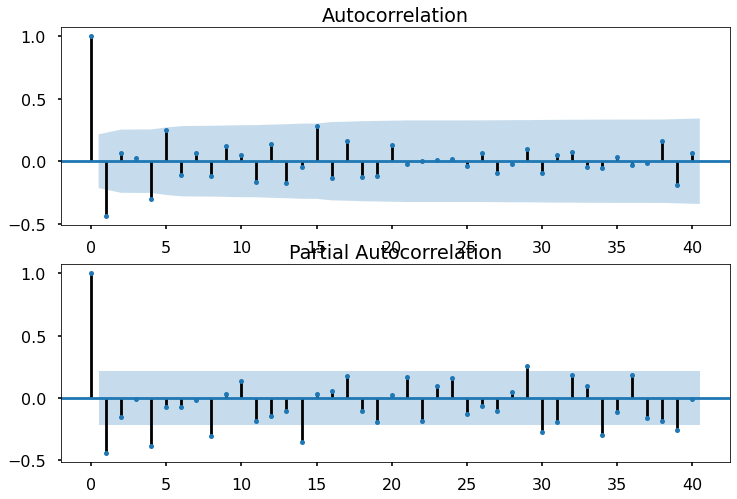

In [94]:
# Auto correlation 
# In this case I only eant to see 40 lags 
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(current_df['Sales First Difference'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(current_df['Sales First Difference'].dropna(),lags=40,ax=ax2) # here we check the AR model 

# Here I defined the q 

In [96]:
auto_arima(current_df['Sales First Difference'].dropna(),  m=12, D=1).summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   83
Model:             SARIMAX(1, 0, 4)x(0, 1, [1], 12)   Log Likelihood               -1717.810
Date:                              Sun, 25 Oct 2020   AIC                           3449.621
Time:                                      15:38:48   BIC                           3465.460
Sample:                                           0   HQIC                          3455.919
                                               - 83                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6087      0.321     -1.895      0.058      -1.238       0.021
ma.L1          0.1532      0.314      0.487      0.626      -0.463       0.770
ma.L2         -0.0581      0.259     -0.225      0.822      -0.565       0.449
ma.L3         -0.1162      0.188     -0.617      0.537      -0.486       0.253
ma.L4         -0.6340      0.168     -3.767      0.000      -0.964      -0.304
ma.S.L12      -0.7416      0.220     -3.372      0.001      -1.173      -0.311
sigma2      7.718e+19   1.58e-21   4.88e+40      0.000    7.72e+19    7.72e+19
===================================================================================
Ljung-Box (Q):                       25.17   Jarque-Bera (JB):                68.00
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                             1.14
Prob(H) (two-sided):                  0.01   Kurtosis:                         7.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.81e+56. Standard errors may be unstable.
"""

In [97]:
pred_number = 6 # I will predict 6 months ahead 
split = len(current_df) - pred_number
train  = current_df[:split]
test  = current_df[split:]

# Daily
# split = int(len(daily) * 0.95)
# train  = daily[:split]
# test  = daily[split:]

In [98]:
# Create models: 

#model1 = SARIMAX(train,order=(1,1,1),seasonal_order=(1,1,1,12))
model2 = SARIMAX(train.volume,order=(1,0,4),seasonal_order=(0,1,1,12)) # using the stationary data 
model3 = SARIMAX(train.volume,order=(1,0,0),seasonal_order=(1,1,1,12)) # without stationary data 
model4 = SARIMAX(train.volume,order=(1,1,1),seasonal_order=(1,1,1,12)) # without stationary data 

# Daily
model5 = SARIMAX(train.volume,order=(1,0,1),seasonal_order=(0,1,1,7)) # (1, 0, 1)x(0, 1, 1, 7)

# Fit the best model
results = model2.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                               volume   No. Observations:                   78
Model:             SARIMAX(1, 0, 4)x(0, 1, [1], 12)   Log Likelihood               -1608.155
Date:                              Sun, 25 Oct 2020   AIC                           3230.309
Time:                                      15:38:49   BIC                           3245.637
Sample:                                  01-31-2010   HQIC                          3236.366
                                       - 06-30-2016                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9737      0.029     33.646      0.000       0.917       1.030
ma.L1         -0.5384      0.162     -3.330      0.001      -0.855      -0.222
ma.L2         -0.0015      0.183     -0.008      0.993      -0.361       0.358
ma.L3         -0.1512      0.159     -0.953      0.341      -0.462       0.160
ma.L4         -0.1162      0.150     -0.775      0.438      -0.410       0.178
ma.S.L12      -0.8465      0.133     -6.344      0.000      -1.108      -0.585
sigma2      7.541e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (Q):                       23.16   Jarque-Bera (JB):               229.43
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                             1.83
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.24e+55. Standard errors may be unstable.
"""

In [99]:
start=len(train)
end=len(train)+len(test)-1  # here I add -1 to exclude the indexing 
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('empty')

# Evaluate the model        
from sklearn.metrics import mean_squared_error
error = mean_squared_error(test.volume, predictions)
print(f'MSE Error: {error:11.10}')

MSE Error: 4.155203477e+19


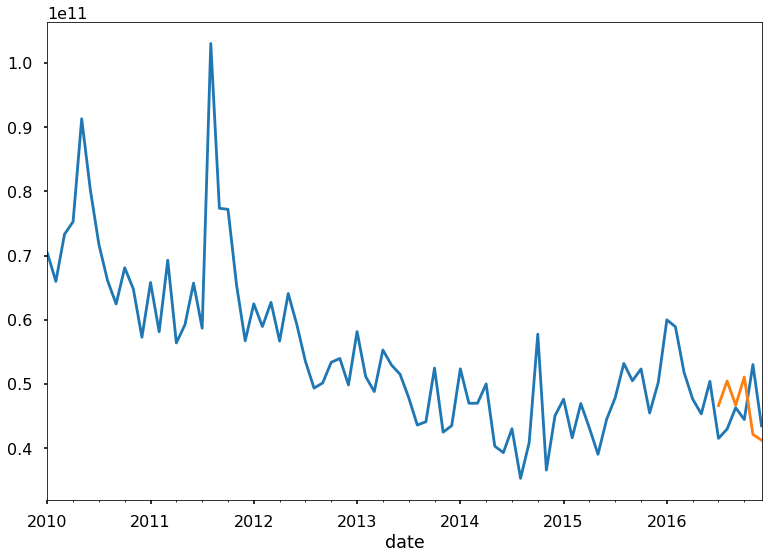

In [100]:
monthly.volume.plot()
predictions.plot()

In [101]:
predictions

2016-07-31    4.664776e+10
2016-08-31    5.046706e+10
2016-09-30    4.670425e+10
2016-10-31    5.109118e+10
2016-11-30    4.215460e+10
2016-12-31    4.126309e+10
Freq: M, Name: empty, dtype: float64

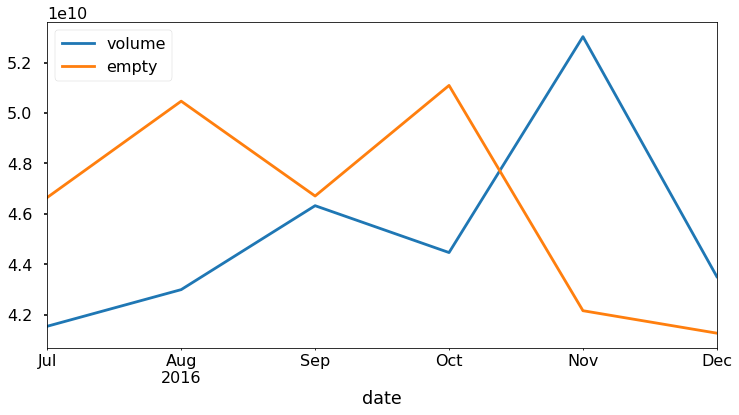

In [102]:
# Results Model 1

# Plot predictions against known values
ax = test.volume.plot(legend=True,figsize=(12,6))
predictions.plot(legend=True)

# MSE Error: 2.690965885e+19

In [ ]:
# Results Model 2

# Plot predictions against known values
ax = test.volume.plot(legend=True,figsize=(12,6))
predictions.plot(legend=True)

# MSE Error: 2.690965885e+19

### Findings:

- Model 2 gave me the best score using monthly data 
- Model 2 is has the lowest error with model2 = SARIMAX(train.volume,order=(1,0,4),seasonal_order=(0,1,1,12))
- Sarima wont work for this particular case
- Daily data is not working properly

### Next steps:
- Hyperparameter tunning

# 3. Stacked LSTM

In [103]:
#Group by day. Here I removed the nans 
df1 = dfx.copy()

In [104]:
df1.head()

,volume
date,
2010-01-04,2.819820e+09
2010-01-05,3.505330e+09
2010-01-06,3.359974e+09
2010-01-07,3.732438e+09
2010-01-08,3.076340e+09


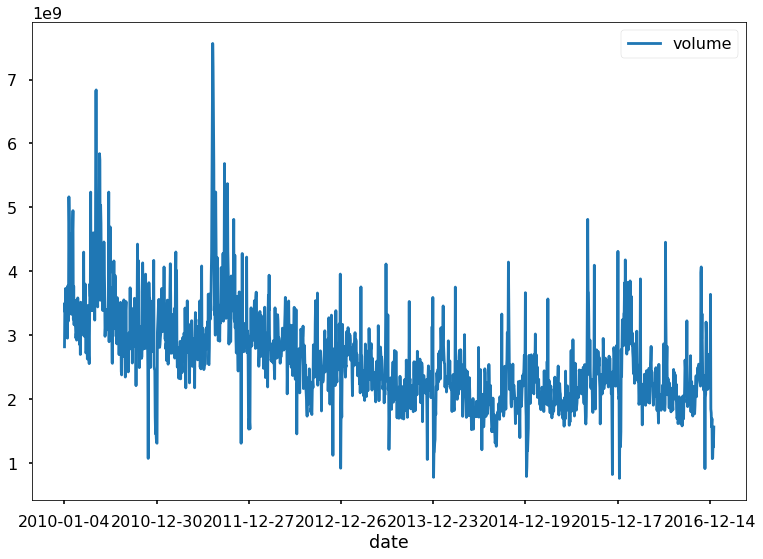

In [105]:
df1.plot()

In [106]:
# 1 Scale
from sklearn.preprocessing import MinMaxScaler

scaler= MinMaxScaler(feature_range=(0,1)) # here I specify the range for min max scaler 
daily = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [107]:
daily[:5]

array([[0.30252611],
       [0.40331856],
       [0.38194641],
       [0.43671092],
       [0.34024288]])

In [108]:
# 2 spliting dataset into train and test split
current_dataset = daily
training_size = int(len(current_dataset)*0.65) # we could tune this parameter as well 
test_size=len(current_dataset)-training_size
train_data,test_data=current_dataset[0:training_size,:],current_dataset[training_size:len(current_dataset),:1]

In [109]:
training_size,test_size

(1145, 617)

In [110]:
# 3 convert an array of values into a dataset matrix

# Here I should choose a relevant time step 
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0] 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [111]:
# 4 reshape into X=t,t+1,t+2,t+3 and Y=t+4

time_step = 100 # here I will consider 100 days to calculate the next step, the more you have te better. This is ann hyperparamater 

X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [112]:
print(X_test.shape), print(ytest.shape)

(516, 100)
(516,)


(None, None)

In [113]:
# 5  Adjust the data for LSTM reshape input to be [samples, time steps, features] which is required for LSTM
# standard  
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [114]:
print(X_test.shape), print(X_train.shape)

(516, 100, 1)
(1044, 100, 1)


(None, None)

In [115]:
### Wrapper functions - Create the Stacked LSTM model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# 5.1 Create the stacked models (LSTM , BILSTM)

def make_lstm_model(time_step): 
    model=Sequential()
    
    model.add(LSTM(50,return_sequences=True,input_shape=(time_step,1)))# the input shape must be adjusted to the number of days for the lookbackwindow

    model.add(LSTM(50,return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(50,return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(50,return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(50,return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(50))
    model.add(Dropout(0.2))

    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam')
    
    return model 

def make_bilstm_model(time_step): 
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(time_step, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model 

In [117]:
import math
from sklearn.metrics import mean_squared_error

test_params = [50,100]
final_param =[100]
train_error_d = {}
test_error_d = {}

#model.summary()

# 6 Fit the model - I will use bi LSTM approach
for time_step in final_param:
    # train and test 
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, ytest = create_dataset(test_data, time_step)
    X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
    
    # Here we define the models 
    model_lstm = make_lstm_model(time_step)
    model_bilstm = make_bilstm_model(time_step)
    current_model =  model_bilstm
    early_stop = EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    # Let's use 32 batch size 
    current_model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=32,verbose=1, callbacks =[early_stop])
    
    train_predict = current_model.predict(X_train)
    test_predict = current_model.predict(X_test)
    
    # Transformback to original form to find the RMSE
    train_predict=scaler.inverse_transform(train_predict)
    test_predict=scaler.inverse_transform(test_predict)
    
    train_error = math.sqrt(mean_squared_error(y_train,train_predict))
    test_error = math.sqrt(mean_squared_error(ytest,test_predict))
    train_error_d[time_step ] = train_error
    test_error_d[time_step ] = test_error

Train on 1044 samples, validate on 516 samples
Epoch 1/100
1044/1044 [==============================] - 8s 8ms/sample - loss: 0.0255 - val_loss: 0.0051
Epoch 2/100
1044/1044 [==============================] - 6s 6ms/sample - loss: 0.0072 - val_loss: 0.0049
Epoch 3/100
1044/1044 [==============================] - 6s 6ms/sample - loss: 0.0065 - val_loss: 0.0048
Epoch 4/100
1044/1044 [==============================] - 6s 6ms/sample - loss: 0.0060 - val_loss: 0.0048
Epoch 5/100
1044/1044 [==============================] - 6s 5ms/sample - loss: 0.0060 - val_loss: 0.0048
Epoch 6/100
1044/1044 [==============================] - 6s 6ms/sample - loss: 0.0059 - val_loss: 0.0047
Epoch 7/100
1044/1044 [==============================] - 6s 6ms/sample - loss: 0.0059 - val_loss: 0.0046
Epoch 8/100
1044/1044 [==============================] - 5s 5ms/sample - loss: 0.0056 - val_loss: 0.0045
Epoch 9/100
1044/1044 [==============================] - 6s 6ms/sample - loss: 0.0056 - val_loss: 0.0045
Epoch 10

Epoch 78/100
1044/1044 [==============================] - 5s 5ms/sample - loss: 0.0042 - val_loss: 0.0036
Epoch 79/100
1044/1044 [==============================] - 6s 6ms/sample - loss: 0.0043 - val_loss: 0.0036
Epoch 80/100
1044/1044 [==============================] - 5s 5ms/sample - loss: 0.0043 - val_loss: 0.0036
Epoch 81/100
1044/1044 [==============================] - 6s 6ms/sample - loss: 0.0043 - val_loss: 0.0038
Epoch 82/100
1044/1044 [==============================] - 5s 5ms/sample - loss: 0.0043 - val_loss: 0.0036
Epoch 83/100
1044/1044 [==============================] - 6s 6ms/sample - loss: 0.0043 - val_loss: 0.0036
Epoch 84/100
1044/1044 [==============================] - 6s 6ms/sample - loss: 0.0042 - val_loss: 0.0036
Epoch 85/100
1044/1044 [==============================] - 6s 6ms/sample - loss: 0.0043 - val_loss: 0.0036
Epoch 86/100
1044/1044 [==============================] - 6s 5ms/sample - loss: 0.0042 - val_loss: 0.0036
Epoch 87/100
1044/1044 [======================

In [118]:
print(train_error_d)
print(test_error_d)


#######
#History
#######

# LSTM
# {50: 2818953082.2686095, 100: 2672676160.3083124}
# {50: 2332170572.309028, 100: 2214628791.2736015}

# BILSTM
# {50: 2826582719.8847837, 100: 2760842591.3469605}
# {50: 2280701038.9157057, 100: 2284666886.916104}

{100: 2840607576.133039}
{100: 2345642656.5169168}


In [119]:
# 7 Predict on train and test data 

train_predict =  current_model.predict(X_train)
test_predict =  current_model.predict(X_test)

In [120]:
# 8 Transformback to original form to find the RMSE

train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [121]:
# 9 Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
train_error = math.sqrt(mean_squared_error(y_train,train_predict))
test_error = math.sqrt(mean_squared_error(ytest,test_predict))
print(f'Train Error: {train_error }')
print(f'Test Error: {test_error }')



#######
#Historical RMSE
#######

# 100 DAYS ERROR 
# Train Error: 2854518701.157978
# Test Error: 2371245579.111049

# Greater train split greater error

# 50 DAYS ERROR + 1 More layer 
# Train Error: 2823674642.641869
# Test Error: 2286034052.849271

# 50 DAYS ERROR + 2 More layers 
# Train Error: 2902894698.5410037
# Test Error: 2318982183.1445646

# 50 DAYS ERROR + More layers and dropout
# Train Error: 2830016460.9744353
# Test Error: 2295034365.4915013

# 25 DAYS ERROR + 32 BATCH SIZE 
# Train Error: 2809688400.9374013
# Test Error: 2306117646.297067

# 50 DAYS ERROR 
# Train Error: 2822943708.782128
# Test Error: 2285582684.1990185

# 60 DAYS ERROR + 32 BATCH SIZE 
# Train Error: 2905435987.9868813
# Test Error: 2351256761.6043873

# 150 DAYS ERROR + 32 BATCH SIZE 
# Train Error: 2799096063.462187 
# Test Error: 2379825251.27331 

# 200 DAYS ERROR + 32 BATCH SIZE 
# Train Error: 2714478135.262076 winner
# Test Error: 2302033020.6785836

# 50 DAYS ERROR + 128 BATCH SIZE 
# Train Error: 2907962985.78682
# Test Error: 2347369897.1422033

# 50 DAYS ERROR + 32 BATCH SIZE + 150 EPOCHS 
# Train Error: 2872092138.7600856
# Test Error: 2389100675.4921746

# 50 DAYS ERROR + 32 BATCH SIZE WINNER
# Train Error: 2805602172.6974745
# Test Error: 2272840835.7860355

Train Error: 2840607576.133039
Test Error: 2345642656.5169168


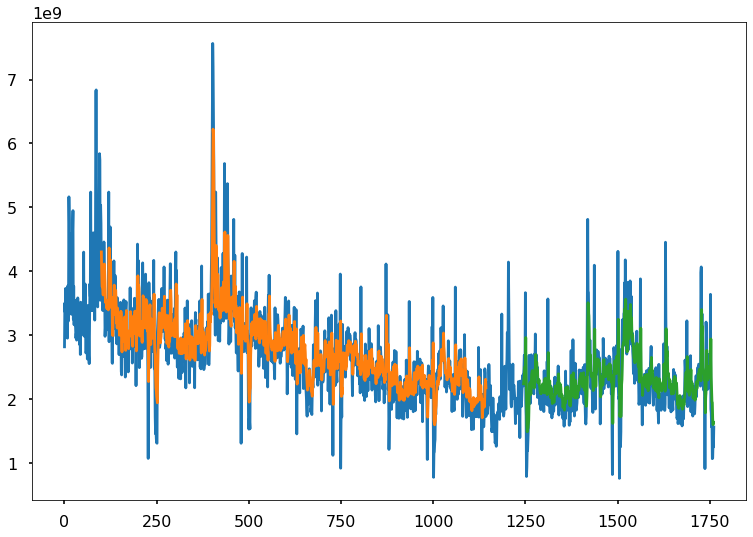

In [122]:
# 10 Plotting LSTM 

# shift train predictions for plotting
#look_back=100

look_back= time_step
trainPredictPlot = np.empty_like(current_dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(current_dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(current_dataset)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(current_dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [124]:
#split = len(test_data) - 100 
split = len(test_data) - time_step
x_input=test_data[split:].reshape(1,-1)
x_input.shape

(1, 100)

In [126]:
# Convert to a list and take all the values from there
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [129]:
# 11 
lst_output=[]
n_steps = time_step
n_days_to_predict = 7

i=0
while(i< n_days_to_predict ): # the number of days we will predict    
    #if(len(temp_input)>100):
    if(len(temp_input)> n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])# here I am shifting one position to the right
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = current_model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = current_model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.1380917]
101
1 day input [0.1552746  0.12592851 0.13197313 0.15826305 0.18778986 0.18086048
 0.16557618 0.12625882 0.14321494 0.14576876 0.1495197  0.15967247
 0.1205755  0.13443042 0.18944638 0.16804953 0.13677499 0.18105946
 0.17586624 0.20996442 0.27202271 0.25328078 0.25820459 0.22729918
 0.20981567 0.36223418 0.17484385 0.16498335 0.21775765 0.19137162
 0.16929118 0.1698637  0.18377138 0.20531827 0.24311404 0.2820522
 0.15308717 0.20064484 0.22242232 0.18176181 0.20612408 0.1432659
 0.21131374 0.15385096 0.20934763 0.17847896 0.14843692 0.16734722
 0.19771024 0.21796227 0.23609654 0.18764459 0.21368284 0.22112891
 0.24465981 0.25547239 0.23319037 0.26259853 0.26181501 0.23760254
 0.23476612 0.2242936  0.21210244 0.47311534 0.48614897 0.32064166
 0.37845043 0.29149342 0.22461182 0.23781617 0.21867379 0.20244833
 0.23359249 0.18136232 0.02236708 0.18586317 0.1937582  0.35937323
 0.33216827 0.20951547 0.23122246 0.2044169  0.28549458 0.2419376
 0.20746046 0.23087129 0.22596154 0.2

In [130]:
#day_new=np.arange(1,101)
day_new=np.arange(1,n_steps + 1)

#day_pred=np.arange(101,131)# these are the number of days I need to predict 30 day pred 
#day_pred=np.arange(101,201)# these are the number of days I need to predict 100 day pred 
day_pred=np.arange(n_steps+1, n_steps + 1 + n_days_to_predict )# these are the number of days I need to predict 100 day pred 

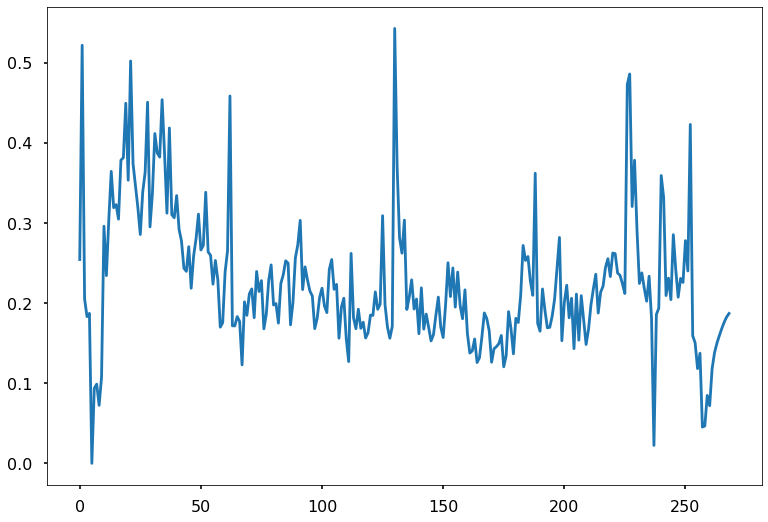

In [131]:
df3=current_dataset.tolist()
df3.extend(lst_output)
plt.plot(df3[1500:])

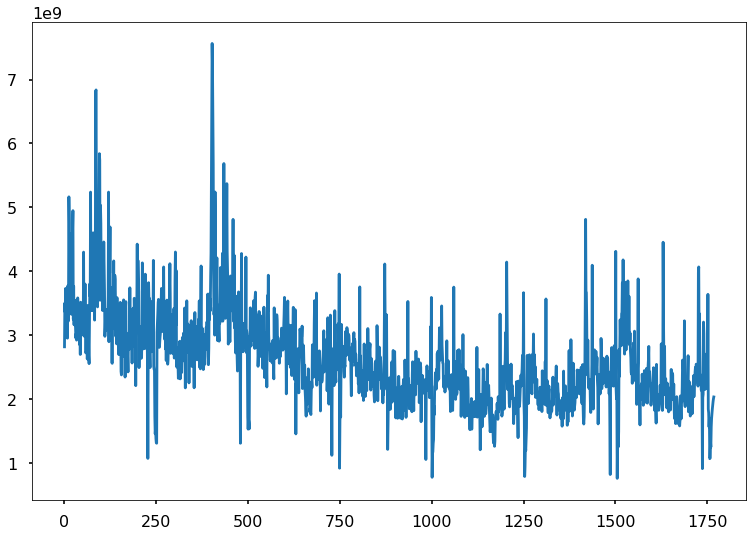

In [132]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)

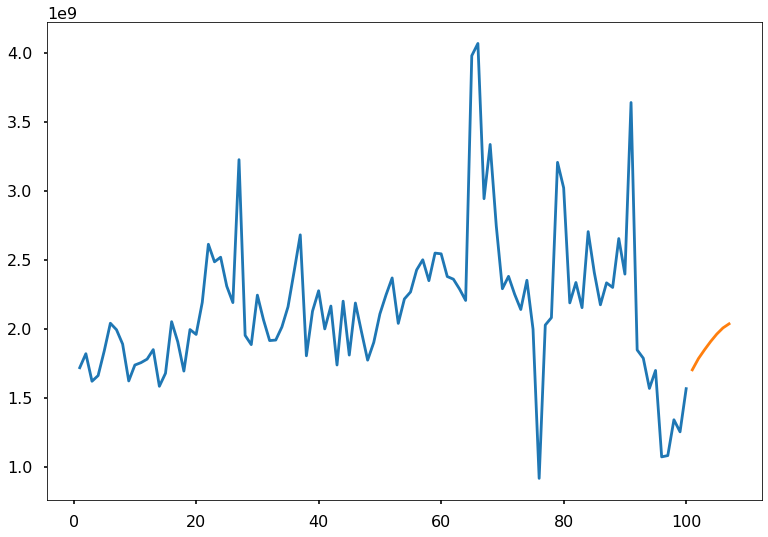

In [134]:
# these is the predictions for 30 days
#split = len(df1) - 100 
split = len(current_dataset) - n_steps
plt.plot(day_new,scaler.inverse_transform(current_dataset[split:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

### Findings: 

- The line is too smooth
- Based on the error it looks like lstm bidirection works better 
- Improve monthly predictions


### Next steps: 
- Add multivariate approach

# 4. XGBOOST 

## 4.1 METHOD 1

In [137]:
df1 = dfx.copy()
df1.tail()

,volume
date,
2016-12-23,1.070337e+09
2016-12-27,1.079626e+09
2016-12-28,1.339229e+09
2016-12-29,1.251894e+09
2016-12-30,1.564858e+09


In [138]:
# Change index 
df1.index = pd.to_datetime(df1.index)

In [139]:
# Holidays
from datetime import date
import holidays

# Select country
us_holidays = holidays.US()

# Print all the holidays in US in year 2018
holidays_lst = []
for k,v in holidays.US(years = [2010,2011,2012,2013,2014,2015,2016]).items():
    holidays_lst.append(k)

In [140]:
def split_data(data, train_size = 0.70):
    split = int(len(data) * train_size)
    return data[:split] , data[split:]

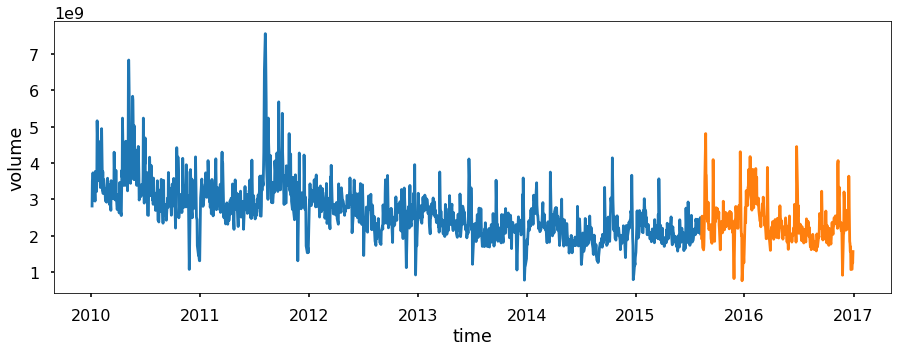

In [141]:
# 1 
train, test = split_data(df1,0.80)

plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('volume')
plt.plot(train.index,train)
plt.plot(test.index,test)
plt.show()

In [ ]:
train.head()

In [142]:
# 2 Fucntion to generate features:
def create_features(df , label = None ):
    """
    Creates time series features from datetime index
    """
        
    df['date'] = pd.to_datetime(df.index)
    df['volume'] = df.volume
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    # add new features 
    df['holiday'] = df.date.apply(lambda x: 1 if x in holidays_lst else 0)

    df.drop('date', axis = 1 , inplace = True )
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear' ,'holiday']]
    
    if label:
        y = df[label]
        return X, y
    return X


In [143]:
# X train and test
X_train, y_train = create_features(train, label = 'volume')
X_test, y_test   = create_features(test, label = 'volume')

X_train.shape, y_train.shape

((1409, 9), (1409,))

In [144]:
X_train.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,holiday
date,,,,,,,,,
2010-01-04,0,0,1,1,2010,4,4,1,0
2010-01-05,0,1,1,1,2010,5,5,1,0
2010-01-06,0,2,1,1,2010,6,6,1,0
2010-01-07,0,3,1,1,2010,7,7,1,0
2010-01-08,0,4,1,1,2010,8,8,1,0


In [145]:
X_train.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,holiday
date,,,,,,,,,
2010-01-04,0,0,1,1,2010,4,4,1,0
2010-01-05,0,1,1,1,2010,5,5,1,0
2010-01-06,0,2,1,1,2010,6,6,1,0
2010-01-07,0,3,1,1,2010,7,7,1,0
2010-01-08,0,4,1,1,2010,8,8,1,0


In [146]:
#Modelling 
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

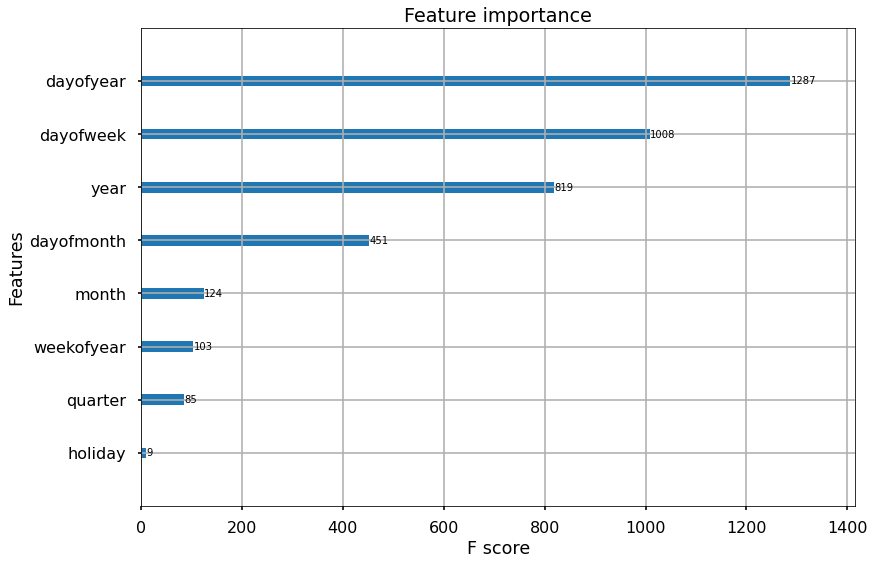

In [147]:
xgb.plot_importance(reg)

In [148]:
#Forecast on the test set 
def plot_performance(base_data, date_from, date_to, title=None):
    plt.figure(figsize=(15,3))
    if title == None:
        plt.title('From {0} To {1}'.format(date_from, date_to))
    else:
        plt.title(title)
        
#     # Change indexes
#     df1.index = pd.to_datetime(df1.index)
#     X_test.index = pd.to_datetime(X_test.index)
    
    plt.plot(df1.volume.index,df1.volume, label='data')
    plt.plot(X_test.index,X_test_pred, label='prediction')
    plt.legend()
    plt.xlim(left=date_from, right=date_to)

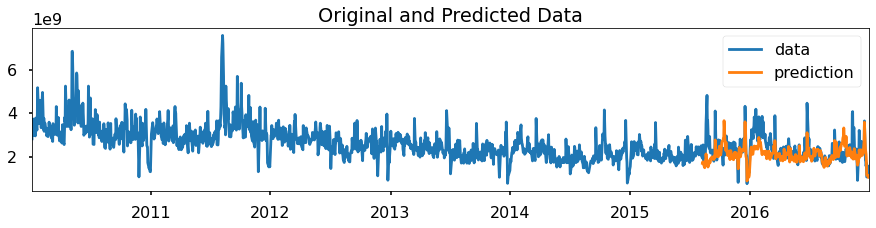

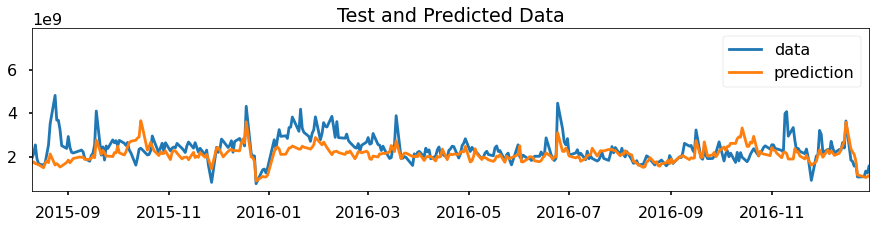

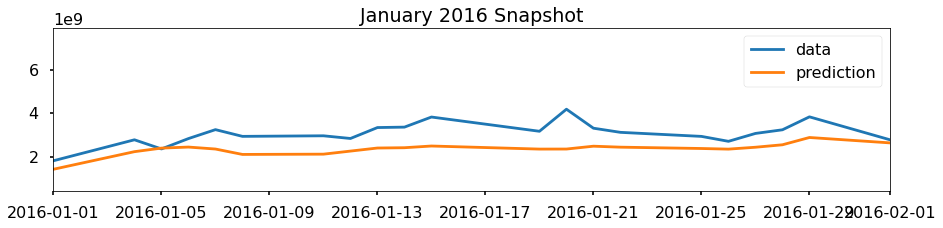

In [149]:
import datetime as dt
test['Prediction'] = reg.predict(X_test) # testing

X_test_pred = reg.predict(X_test)

plot_performance(df1.volume, df1.volume.index[0].date(), df1.volume.index[-1].date(),
                 'Original and Predicted Data')

plot_performance(y_test, y_test.index[0].date(), y_test.index[-1].date(),
                 'Test and Predicted Data')

plot_performance(y_test, dt.datetime(2016, 1, 1), dt.datetime(2016, 2, 1), 'January 2016 Snapshot')

plt.legend()

plt.show()

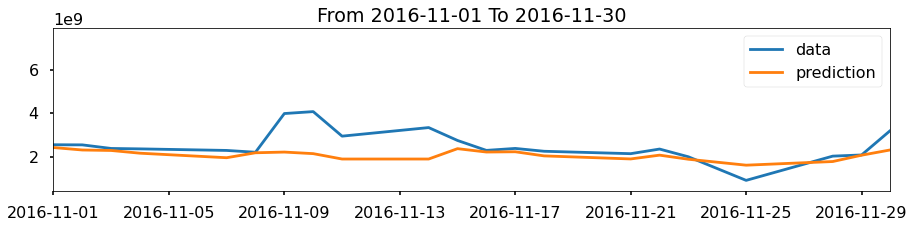

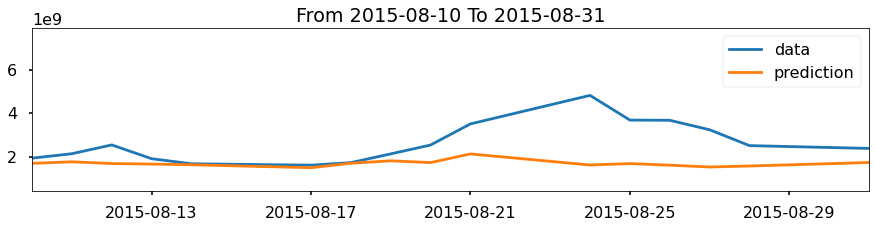

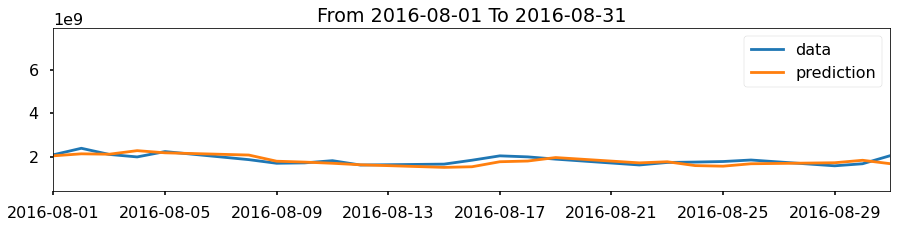

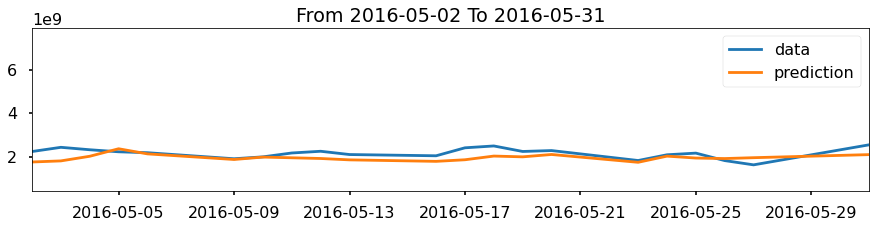

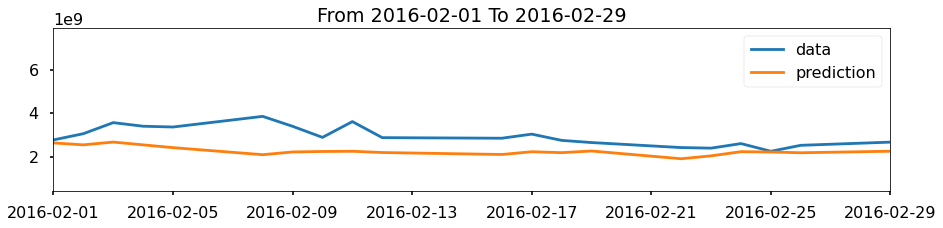

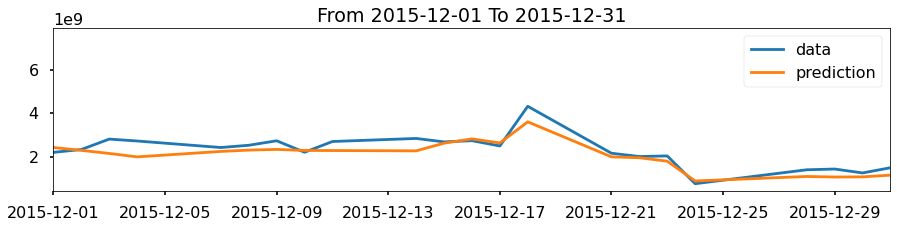

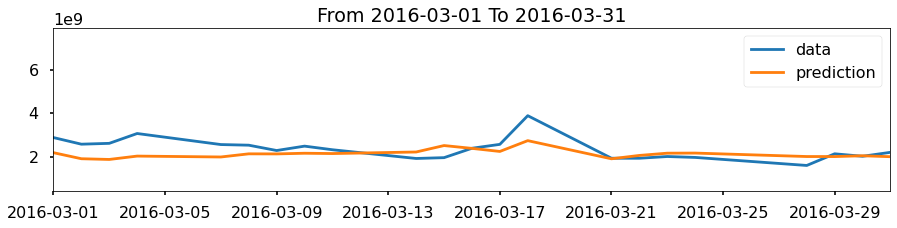

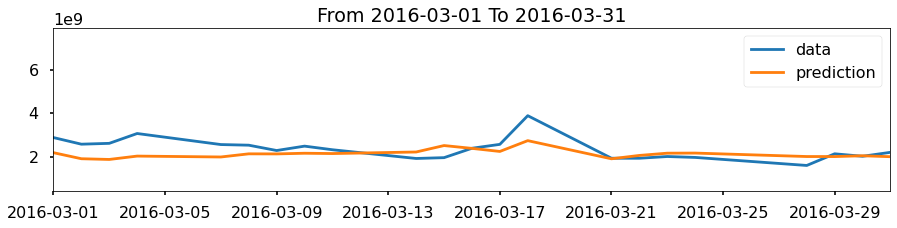

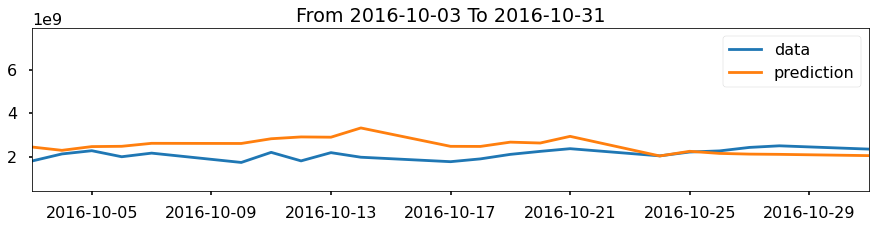

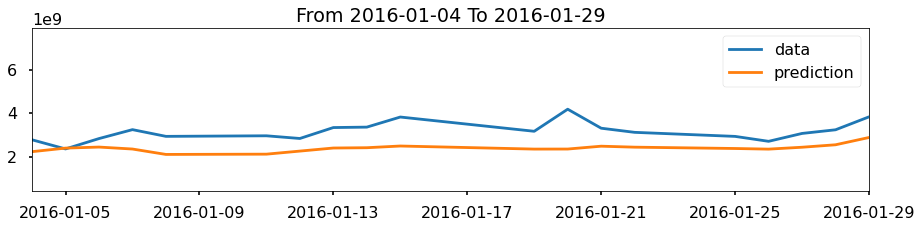

In [150]:
random_months = X_test[['year', 'month']].sample(10)
for month in random_months.iterrows():
    index = (X_test.year == month[1].year) & \
            (X_test.month == month[1].month)
    data = y_test[index]
    plot_performance(data, data.index[0].date(), data.index[-1].date())

In [151]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y_true=y_test,
                   y_pred=X_test_pred)

mae = mean_absolute_error(y_true=y_test,
                   y_pred=X_test_pred)
print(f'MSE: {mse}, MAE {mae}')

# Results: MSE: 3.153429156824707e+17, MAE 398039013.42776203

MSE: 3.153429156824707e+17, MAE 398039013.42776203


In [152]:
# Look at Worst and Best Predicted Days 

test['error'] = test['volume'] - test['Prediction']

test['abs_error'] = test['error'].apply(np.abs)

error_by_day = test.groupby(['year','month','dayofmonth']).mean()[['volume','Prediction','error','abs_error']]

In [153]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

volume    Prediction         error     abs_error
year month dayofmonth                                                        
2016 10    14          1.976151e+09  3.319060e+09 -1.342909e+09  1.342909e+09
2015 10    15          2.388666e+09  3.652088e+09 -1.263422e+09  1.263422e+09
           12          1.613414e+09  2.758226e+09 -1.144811e+09  1.144811e+09
2016 10    12          1.808651e+09  2.907136e+09 -1.098485e+09  1.098485e+09
2015 10    16          2.315990e+09  3.354988e+09 -1.038998e+09  1.038998e+09
           13          1.941283e+09  2.854266e+09 -9.129833e+08  9.129833e+08
2016 10    10          1.736660e+09  2.607225e+09 -8.705655e+08  8.705655e+08
           13          2.186095e+09  2.895084e+09 -7.089887e+08  7.089887e+08
           17          1.771829e+09  2.475709e+09 -7.038803e+08  7.038803e+08
     11    25          9.144028e+08  1.611418e+09 -6.970149e+08  6.970149e+08

In [154]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

volume    Prediction         error     abs_error
year month dayofmonth                                                        
2015 8     24          4.812893e+09  1.619081e+09  3.193812e+09  3.193812e+09
           26          3.670849e+09  1.611336e+09  2.059513e+09  2.059513e+09
           25          3.679944e+09  1.683981e+09  1.995963e+09  1.995963e+09
2016 11    10          4.068676e+09  2.140649e+09  1.928026e+09  1.928026e+09
     1     20          4.179022e+09  2.351781e+09  1.827242e+09  1.827242e+09
     11    9           3.980032e+09  2.212632e+09  1.767400e+09  1.767400e+09
     2     8           3.850441e+09  2.092707e+09  1.757734e+09  1.757734e+09
2015 8     27          3.236639e+09  1.528012e+09  1.708627e+09  1.708627e+09
2016 11    14          3.336197e+09  1.893881e+09  1.442315e+09  1.442315e+09
2015 8     21          3.505574e+09  2.126840e+09  1.378734e+09  1.378734e+09

In [155]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

volume    Prediction      error  abs_error
year month dayofmonth                                                  
2016 12    27          1.079626e+09  1.078349e+09  1276460.0  1276460.0
     6     6           1.908936e+09  1.906794e+09  2141404.0  2141404.0
     12    6           2.152560e+09  2.150137e+09  2423324.0  2423324.0
     10    24          2.038488e+09  2.033816e+09  4671908.0  4671908.0
     3     16          2.387494e+09  2.381864e+09  5630720.0  5630720.0
2015 10    1           2.488184e+09  2.482455e+09  5729072.0  5729072.0
2016 9     6           1.993701e+09  1.985008e+09  8692916.0  8692916.0
           1           1.905218e+09  1.895732e+09  9486488.0  9486488.0
     8     3           2.104508e+09  2.114142e+09 -9634196.0  9634196.0
     5     10          1.992948e+09  1.982973e+09  9974060.0  9974060.0

### Findings
- Add lags

## 4.2 Method 2

In [156]:
# forecast monthly births with xgboost
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error ,mean_squared_error
from xgboost import XGBRegressor
from matplotlib import pyplot

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(asarray([testX]))
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test): 
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_squared_error(test[:, -1], predictions)
	return error, test[:, -1], predictions


In [160]:
#test_df
df1 = dfx.copy()
values = df1.values

In [161]:
values

array([[2.8198202e+09],
       [3.5053298e+09],
       [3.3599735e+09],
       ...,
       [1.3392288e+09],
       [1.2518942e+09],
       [1.5648580e+09]])

In [162]:
# 1 

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

data1 = series_to_supervised(values,3)

In [163]:
data1[1]

array([3.5053298e+09, 3.3599735e+09, 3.7324379e+09, 3.0763395e+09])

In [164]:
data1[0]

array([2.8198202e+09, 3.5053298e+09, 3.3599735e+09, 3.7324379e+09])

In [168]:
# 1 create a series of the df 

day_to_predict = 12
n_steps = 15

# transform the time series data into supervised learning
data = series_to_supervised(values, n_in = n_steps)
df1 = dfx.copy()
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

train, test = train_test_split(data,12)
history = [x for x in train]

# evaluate
mse, y, yhat = walk_forward_validation(data, day_to_predict)# number of days I will predict 
print('MSE: %.3f' % mse)



# 6 days  
#MSE: 308762769755849920.000

# 20 days  
#MSE: 201359457099437056.000 WINNER 

# 100 days  
# MSE: 212089207700754272.000

# 14 days  
#MSE: 229616926935145120.000

# 2 weeks - weekly 

#MSE: 8777424071385341952.000

# 4 weeks - weekly 

#MSE: 8954593523296280576.000

# 1 weeks - weekly 
# MSE: 14957971749329985536.000

# 8 weeks - weekly 
#8005289766451825664.000

# 16 weeks - weekly 
#6280470131074245632.000

>expected=2653726400.0, predicted=2313522176.0
>expected=2395983600.0, predicted=2585758208.0
>expected=3640330400.0, predicted=3459290112.0
>expected=1845894600.0, predicted=2127395584.0
>expected=1785746300.0, predicted=1279932288.0
>expected=1566751600.0, predicted=1877427328.0
>expected=1696970700.0, predicted=1723844096.0
>expected=1070337300.0, predicted=1866212096.0
>expected=1079625900.0, predicted=1823762048.0
>expected=1339228800.0, predicted=1700600448.0
>expected=1251894200.0, predicted=1184984064.0
>expected=1564858000.0, predicted=1525075072.0
MSE: 161722126763656096.000


In [169]:
history

[array([2.8198202e+09, 3.5053298e+09, 3.3599735e+09, 3.7324379e+09,
        3.0763395e+09, 2.9699188e+09, 3.4431486e+09, 3.1543331e+09,
        2.9546356e+09, 3.7724843e+09, 3.2183907e+09, 3.6498833e+09,
        5.1648500e+09, 4.7572486e+09, 3.5155558e+09, 3.9434339e+09]),
 array([3.5053298e+09, 3.3599735e+09, 3.7324379e+09, 3.0763395e+09,
        2.9699188e+09, 3.4431486e+09, 3.1543331e+09, 2.9546356e+09,
        3.7724843e+09, 3.2183907e+09, 3.6498833e+09, 5.1648500e+09,
        4.7572486e+09, 3.5155558e+09, 3.9434339e+09, 4.2470241e+09]),
 array([3.3599735e+09, 3.7324379e+09, 3.0763395e+09, 2.9699188e+09,
        3.4431486e+09, 3.1543331e+09, 2.9546356e+09, 3.7724843e+09,
        3.2183907e+09, 3.6498833e+09, 5.1648500e+09, 4.7572486e+09,
        3.5155558e+09, 3.9434339e+09, 4.2470241e+09, 4.5903585e+09]),
 array([3.7324379e+09, 3.0763395e+09, 2.9699188e+09, 3.4431486e+09,
        3.1543331e+09, 2.9546356e+09, 3.7724843e+09, 3.2183907e+09,
        3.6498833e+09, 5.1648500e+09, 4.75

In [ ]:
# # Grid search 

# def fn (n_steps = 6, df=values , day_to_predict = 12): 
#     data = series_to_supervised(df, n_in = n_steps)
#     mse, y, yhat = walk_forward_validation(data, day_to_predict)# number of days I will predict 
#     print('MSE: %.3f' % mse)
    
# # check how many steps give you the lowest error 

# steps = [n for n in range(10,110,5)]

# for step in steps: 
#     step,fn(n_steps=step)


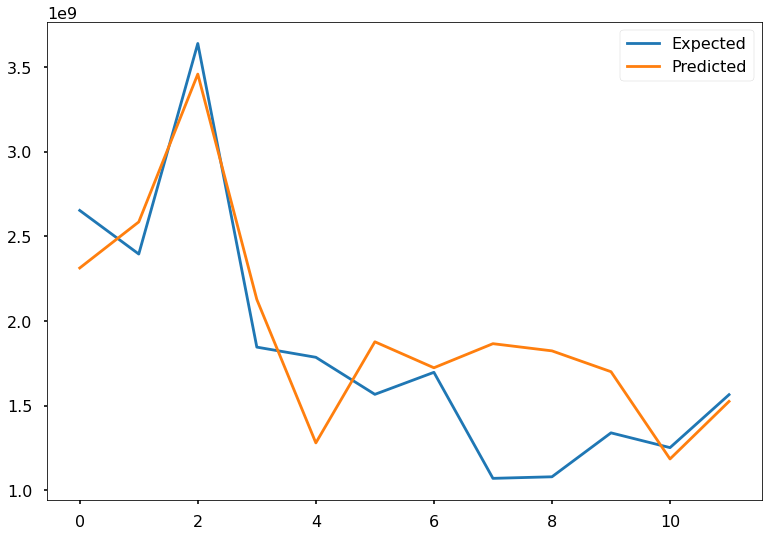

In [170]:
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

In [172]:
# finalize model and make a prediction for monthly births with xgboost
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from xgboost import XGBRegressor

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

# load the dataset
df1 = dfx.copy()
series = df1
values = series.values
n_days = 15
# transform the time series data into supervised learning

train = series_to_supervised(values, n_in= n_days , n_out = 1)
# split into input and output columns
trainX, trainy = train[:, :-1], train[:, -1]
# fit model
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(trainX, trainy)
# construct an input for a new preduction

row = values[-n_days:].flatten()

# make a one-step prediction
yhat = model.predict(asarray([row]))
print('Input: %s, Predicted: %.3f' % (row, yhat[0]))

Input: [2.1732598e+09 2.3324815e+09 2.2990893e+09 2.6537264e+09 2.3959836e+09
 3.6403304e+09 1.8458946e+09 1.7857463e+09 1.5667516e+09 1.6969707e+09
 1.0703373e+09 1.0796259e+09 1.3392288e+09 1.2518942e+09 1.5648580e+09], Predicted: 1905921024.000


In [173]:
df1.tail()

,volume
date,
2016-12-23,1.070337e+09
2016-12-27,1.079626e+09
2016-12-28,1.339229e+09
2016-12-29,1.251894e+09
2016-12-30,1.564858e+09


### Findings:
- Add a multivariate model approach

# NEXT STEPS
- Add lags
- Explore stacking methods
- Adapt to multivariate
- LSTM - Add more layers to the bilstm , use mse to be able to compare with xgboost